In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import gc
import warnings
from datetime import datetime

# 1.源数据的读取

In [3]:
df_origin = pd.read_csv('../UserBehavior.csv')

# 2.源数据补全列名，打印信息

In [4]:
df_origin.columns = ['UserID', 'ItemID', 'CatogoryID', 'BehaviorType', 'TimeStamps']
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150806 entries, 0 to 100150805
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   UserID        int64 
 1   ItemID        int64 
 2   CatogoryID    int64 
 3   BehaviorType  object
 4   TimeStamps    int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


# 3.取样100w条数据进行便于后续分析

In [5]:

df_Second = df_origin.dropna()
df_Second = df_Second.drop_duplicates(subset=['UserID', 'ItemID', 'TimeStamps'])
df_Second = df_Second.sample(frac=0.01, random_state=1)
df_Second.to_csv('../UserBehavior-2.csv')


# 4.提高时间信息的可读性

In [6]:
df_Second = pd.read_csv('../UserBehavior-2.csv')
startTime = time.mktime(time.strptime("2017-11-25 00:00:00", "%Y-%m-%d %H:%M:%S"))
endTime = time.mktime(time.strptime("2017-12-3 23:59:59", "%Y-%m-%d %H:%M:%S"))
df_Second = df_Second.loc[(df_Second['TimeStamps'] >= startTime) & (df_Second['TimeStamps'] <= endTime)]


df_Second["time"] = df_Second["TimeStamps"].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
df_Second['weekday'] = pd.to_datetime(df_Second['time'], format="%Y-%m-%d %H:%M:%S").dt.day_name()
df_Second['date'] = df_Second['time'].str[0:10]
df_Second['date'] = pd.to_datetime(df_Second['date'], format='%Y-%m-%d')
df_Second['time'] = df_Second['time'].str[11:13]
df_Second['time'] = df_Second['time'].astype(int)
df_Second['hour'] = pd.cut(df_Second['time'], bins=[-1, 5, 10, 13, 18, 24], labels=['morning', 'forenoon', 'noon', 'afternoon', 'night'])
df_Second = df_Second.drop(columns=['time'])

df_Second.head()

,Unnamed: 0,UserID,ItemID,CatogoryID,BehaviorType,TimeStamps,weekday,date,hour
0,2708530,205131,2664389,1320293,pv,1511795351,Monday,2017-11-27,night
1,15830413,808910,2619425,2355072,pv,1511680205,Sunday,2017-11-26,afternoon
2,18307222,92422,5062111,3138705,pv,1511645947,Sunday,2017-11-26,morning
3,78006593,901476,1632442,2013232,pv,1511715532,Monday,2017-11-27,morning
4,89157934,49272,2371018,3184456,pv,1512281047,Sunday,2017-12-03,afternoon


# 5.数据验证

In [7]:
print(df_Second.duplicated().any())
print(df_Second.isnull().any())
print(df_Second.date.min())
print(df_Second.date.max())

False
Unnamed: 0      False
UserID          False
ItemID          False
CatogoryID      False
BehaviorType    False
TimeStamps      False
weekday         False
date            False
hour            False
dtype: bool
2017-11-25 00:00:00
2017-12-03 00:00:00


BehaviorType
buy      3.356369
cart     8.762414
fav      4.418669
pv      83.462548
Name: UserID, dtype: float64

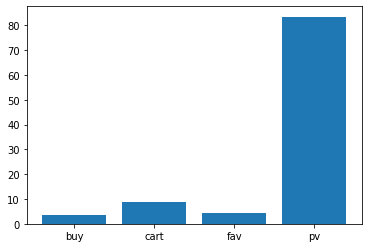

In [8]:
bt_persent = df_Second.groupby(by='BehaviorType')['UserID'].nunique() / df_Second.groupby(by='BehaviorType')['UserID'].nunique().sum()*100
plt.bar(bt_persent.index,bt_persent.values)
bt_persent

# 6.用户行为分析

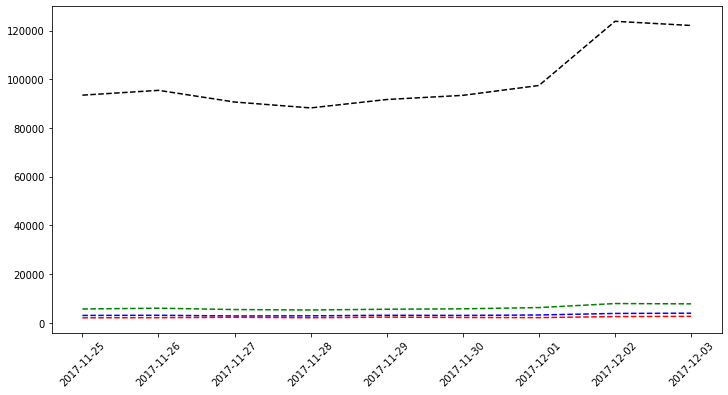

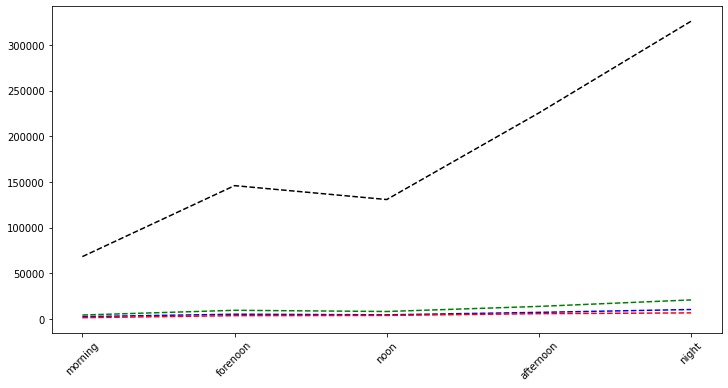

,UserID,MostPvCatogory,MostFavCatogory,MostCartCatogory,MostBuyCatogory
0,205131,1320293,NaN,NaN,NaN
1,808910,2355072,NaN,NaN,NaN
2,92422,2735466,NaN,NaN,NaN
3,901476,"48094,269606,982926,1609851,2013232,3795340,41...",NaN,NaN,NaN
4,49272,3091480,NaN,NaN,NaN


In [32]:
#把用户行为根据天数分割
day_pv_count = df_Second[df_Second['BehaviorType']=='pv'].groupby(by='date').count()
day_fav_count = df_Second[df_Second['BehaviorType']=='fav'].groupby(by='date').count()
day_cart_count = df_Second[df_Second['BehaviorType']=='cart'].groupby(by='date').count()
day_buy_count = df_Second[df_Second['BehaviorType']=='buy'].groupby(by='date').count()

plt.figure(figsize=(12,6))
plt.plot(list(day_pv_count['BehaviorType'].index),list(day_pv_count['BehaviorType'].values),linestyle='--',color='black')
plt.plot(list(day_fav_count['BehaviorType'].index),list(day_fav_count['BehaviorType'].values),linestyle='--',color='blue')
plt.plot(list(day_cart_count['BehaviorType'].index),list(day_cart_count['BehaviorType'].values),linestyle='--',color='green')
plt.plot(list(day_buy_count['BehaviorType'].index),list(day_buy_count['BehaviorType'].values),linestyle='--',color='red')
plt.xticks(rotation=45)
plt.show()
#把用户行为根据时间分割
day_pv_count = df_Second[df_Second['BehaviorType']=='pv'].groupby(by='hour').count()
day_fav_count = df_Second[df_Second['BehaviorType']=='fav'].groupby(by='hour').count()
day_cart_count = df_Second[df_Second['BehaviorType']=='cart'].groupby(by='hour').count()
day_buy_count = df_Second[df_Second['BehaviorType']=='buy'].groupby(by='hour').count()

plt.figure(figsize=(12,6))
plt.plot(list(day_pv_count['BehaviorType'].index),list(day_pv_count['BehaviorType'].values),linestyle='--',color='black')
plt.plot(list(day_fav_count['BehaviorType'].index),list(day_fav_count['BehaviorType'].values),linestyle='--',color='blue')
plt.plot(list(day_cart_count['BehaviorType'].index),list(day_cart_count['BehaviorType'].values),linestyle='--',color='green')
plt.plot(list(day_buy_count['BehaviorType'].index),list(day_buy_count['BehaviorType'].values),linestyle='--',color='red')
plt.xticks(rotation=45)
plt.show()
#提取每个用户的浏览，收藏，加购物车，购买数据

df_user = df_Second['UserID'].drop_duplicates()
df_pv = df_Second.loc[df_Second['BehaviorType']=='pv',['UserID','ItemID', 'CatogoryID']]
df_fav = df_Second.loc[df_Second['BehaviorType']=='fav',['UserID','ItemID', 'CatogoryID']]
df_cart = df_Second.loc[df_Second['BehaviorType']=='cart',['UserID','ItemID', 'CatogoryID']]
df_buy = df_Second.loc[df_Second['BehaviorType']=='buy',['UserID','ItemID', 'CatogoryID']]
#把每个用户最多浏览的商品类数据整理出来

df_pv_count = df_pv.groupby(['UserID','CatogoryID']).ItemID.count().reset_index()
df_pv_count.rename(columns={'ItemID':'CatogoryCounts'},inplace=True)
df_pv_max = df_pv_count.groupby('UserID').CatogoryCounts.max().reset_index()
df_pv_max.rename(columns={'CatogoryCounts':'FavoriteCatogory'},inplace=True)
df_pv_count= pd.merge(df_pv_count,df_pv_max,how='left',on='UserID')
df_pv_count['CatogoryID']=df_pv_count['CatogoryID'].astype(str)
df_pv = df_pv_count.loc[df_pv_count['CatogoryCounts']==df_pv_count['FavoriteCatogory'],'CatogoryID'].groupby(df_pv_count['UserID']).aggregate(lambda x:','.join(x)).reset_index()
df_user = pd.merge(df_user,df_pv,how='left',on='UserID')
df_user.rename(columns={'CatogoryID':'MostPvCatogory'},inplace=True)
#把每个用户最多加购物车的商品类数据整理出来

df_fav_count = df_fav.groupby(['UserID','CatogoryID']).ItemID.count().reset_index()
df_fav_count.rename(columns={'ItemID':'CatogoryCounts'},inplace=True)
df_fav_max = df_fav_count.groupby('UserID').CatogoryCounts.max().reset_index()
df_fav_max.rename(columns={'CatogoryCounts':'FavoriteCatogory'},inplace=True)
df_fav_count= pd.merge(df_fav_count,df_fav_max,how='left',on='UserID')
df_fav_count['CatogoryID']=df_fav_count['CatogoryID'].astype(str)
df_fav = df_fav_count.loc[df_fav_count['CatogoryCounts']==df_fav_count['FavoriteCatogory'],'CatogoryID'].groupby(df_fav_count['UserID']).aggregate(lambda x:','.join(x)).reset_index()
df_fav['UserID'] = df_fav['UserID'].astype(str)
df_user = pd.merge(df_user,df_fav,how='left',on='UserID')
df_user.rename(columns={'CatogoryID':'MostFavCatogory'},inplace=True)
#把每个用户最多收藏的商品类数据整理出来

df_cart_count = df_cart.groupby(['UserID','CatogoryID']).ItemID.count().reset_index()
df_cart_count.rename(columns={'ItemID':'CatogoryCounts'},inplace=True)
df_cart_max = df_cart_count.groupby('UserID').CatogoryCounts.max().reset_index()
df_cart_max.rename(columns={'CatogoryCounts':'FavoriteCatogory'},inplace=True)
df_cart_count= pd.merge(df_cart_count,df_cart_max,how='left',on='UserID')
df_cart_count['CatogoryID']=df_cart_count['CatogoryID'].astype(str)
df_cart = df_cart_count.loc[df_cart_count['CatogoryCounts']==df_cart_count['FavoriteCatogory'],'CatogoryID'].groupby(df_cart_count['UserID']).aggregate(lambda x:','.join(x)).reset_index()
df_user = pd.merge(df_user,df_cart,how='left',on='UserID')
df_user.rename(columns={'CatogoryID':'MostCartCatogory'},inplace=True)
#把每个用户最多购买的商品类数据整理出来

df_buy_count = df_buy.groupby(['UserID','CatogoryID']).ItemID.count().reset_index()
df_buy_count.rename(columns={'ItemID':'CatogoryCounts'},inplace=True)
df_buy_max = df_buy_count.groupby('UserID').CatogoryCounts.max().reset_index()
df_buy_max.rename(columns={'CatogoryCounts':'FavoriteCatogory'},inplace=True)
df_buy_count= pd.merge(df_buy_count,df_buy_max,how='left',on='UserID')
df_buy_count['CatogoryID']=df_buy_count['CatogoryID'].astype(str)
df_buy = df_buy_count.loc[df_buy_count['CatogoryCounts']==df_buy_count['FavoriteCatogory'],'CatogoryID'].groupby(df_buy_count['UserID']).aggregate(lambda x:','.join(x)).reset_index()
df_user = pd.merge(df_user,df_buy,how='left',on='UserID')
df_user.rename(columns={'CatogoryID':'MostBuyCatogory'},inplace=True)
df_user.fillna(0)
#填充空值为0
df_user.head()

In [10]:
def R(t):
    if t in [0,1,2]:
        return 4
    elif t in [3,4]:
        return 3
    elif t in [5,6]:
        return 2
    else:
        return 1

def F(n):
    if n == 1:
        return 1
    elif n == 2:
        return 2
    elif n == 3:
        return 3
    else:
        return 4

# 7.用户总体推荐

In [11]:
df_buy = df_Second[df_Second['BehaviorType']=='buy']
Near_buy_tstamp = df_buy.groupby(by='UserID')['TimeStamps'].max() #得出用户最近购买时间
df_buy = pd.DataFrame(data=Near_buy_tstamp)
diff_time = (endTime - Near_buy_tstamp).astype('int') #用户最近购买时间距离结束时间长短
diff_day = (diff_time/(24*60*60)).astype('int')
df_Second['diffDay'] = diff_day
df_Second['R'] = df_Second['diffDay'].apply(R)
df_Second.drop(labels=['diffDay'],axis=1,inplace=True)


df_Second['Frequency'] = df_Second['UserID'].value_counts().astype('int')
df_Second['F'] = df_Second['Frequency'].apply(F)
df_Second.drop(labels=['Frequency'],axis=1,inplace=True)


df_Second['UserCategory'] = np.select([(df_Second['R']>2.75)&(df_Second['F']>1.02),(df_Second['R']>2.75)&(df_Second['F']<=1.02),
          (df_Second['R']<=2.75)&(df_Second['F']>1.02),(df_Second['R']<2.75)&(df_Second['F']<=1.02)],
         ['重要价值用户','重要保持用户','重要发展用户','一般价值用户'])
df_Second.head()



,Unnamed: 0,UserID,ItemID,CatogoryID,BehaviorType,TimeStamps,weekday,date,hour,R,F,UserCategory
0,2708530,205131,2664389,1320293,pv,1511795351,Monday,2017-11-27,night,1,4,重要发展用户
1,15830413,808910,2619425,2355072,pv,1511680205,Sunday,2017-11-26,afternoon,1,2,重要发展用户
2,18307222,92422,5062111,3138705,pv,1511645947,Sunday,2017-11-26,morning,1,4,重要发展用户
3,78006593,901476,1632442,2013232,pv,1511715532,Monday,2017-11-27,morning,1,1,一般价值用户
4,89157934,49272,2371018,3184456,pv,1512281047,Sunday,2017-12-03,afternoon,1,2,重要发展用户
